In [133]:
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [135]:
with open("/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/annotations/instances_train2017.json", "r") as f:
    data = json.load(f)

first_image = data["images"][0]
print("Image filename:", first_image["file_name"])

#getting a bounding box from the json file
first_annotation = data["annotations"][0]
print("Bounding box (x, y, width, height):", first_annotation["bbox"])


Image filename: 000001.jpg
Bounding box (x, y, width, height): [167.04, 40.21, 202.79, 131.34]


## Data Exploration/Loading the data

In [138]:
def load_annotations(annotation_path, num_categories=6):
    """
    Loads image filenames and multi-label binary vectors from a COCO-style annotation file.

    Returns:
        image_label_list: list of tuples (filename, binary label vector)
    """
    with open(annotation_path, "r") as f:
        data = json.load(f)

    image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    image_to_categories = defaultdict(set)
    
    for ann in data['annotations']:
        image_to_categories[ann['image_id']].add(ann['category_id'])

    image_label_list = []
    for image_id, filename in image_id_to_filename.items():
        label_vector = np.zeros(num_categories)
        for cat_id in image_to_categories[image_id]:
            if cat_id < num_categories:
                label_vector[cat_id] = 1
        image_label_list.append((filename, label_vector))

    return image_label_list


In [140]:
train_data = load_annotations("/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/annotations/instances_train2017.json")
test_data = load_annotations("/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/annotations/instances_test2017.json")

In [142]:
print(data.keys())

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


In [144]:
#understanding the different columns in the data
print("LICENSES:", data["licenses"][0])
print("INFO:", data["info"])
print("CATEGORIES:", data["categories"][0])
print("IMAGES:", data["images"][0])
print("ANNOTATIONS:", data["annotations"][0])

LICENSES: {'name': 'CarDD', 'id': 0, 'url': 'https://cardd-ustc.github.io/'}
INFO: {'contributor': 'Xinkuang Wang, Wenjing Li, Zhongcheng Wu', 'date_created': '2022.05.01', 'description': 'CarDD for car damage detection in COCO Format.', 'url': 'https://cardd-ustc.github.io/', 'version': 'v1.0'}
CATEGORIES: {'id': 1, 'name': 'dent'}
IMAGES: {'id': 1, 'width': 1000, 'height': 750, 'file_name': '000001.jpg', 'license': 0}
ANNOTATIONS: {'id': 1, 'image_id': 1, 'category_id': 2, 'segmentation': [[233.35, 46.65, 217.25, 58.24, 210.82, 65.97, 204.38, 78.2, 197.3, 93.0, 192.15, 104.59, 187.0, 112.96, 180.56, 123.91, 174.12, 135.49, 169.61, 144.51, 167.04, 154.16, 167.04, 165.11, 175.41, 170.9, 185.71, 171.55, 196.01, 167.68, 205.02, 161.24, 214.03, 154.81, 224.33, 148.37, 233.99, 141.93, 244.29, 134.21, 256.52, 128.41, 267.47, 125.19, 277.77, 122.62, 288.71, 119.4, 298.37, 116.82, 310.6, 113.61, 322.83, 109.1, 333.13, 105.88, 344.08, 103.95, 355.02, 101.37, 366.61, 97.51, 369.83, 87.21, 364.6

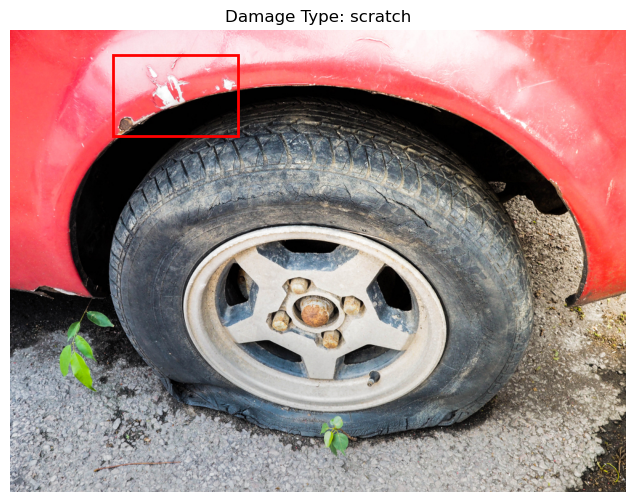

In [146]:
#mapping from image ID to file name
image_id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}

#first annotation
annotation = data["annotations"][0]
image_id = annotation["image_id"]
bbox = annotation["bbox"]  # [x, y, width, height]
category_id = annotation["category_id"]

image_filename = image_id_to_filename[image_id]
image_path = f"/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/train2017/{image_filename}"

img = Image.open(image_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
ax = plt.gca()

#drawing the bounding box on the image
x, y, w, h = bbox
rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

categories = {cat["id"]: cat["name"] for cat in data["categories"]}
plt.title(f"Damage Type: {categories[category_id]}")
plt.axis('off')
plt.show()


In [148]:
#checking the different category names and IDs
for cat in data['categories']:
    print(f"ID: {cat['id']}, Name: {cat['name']}")


ID: 1, Name: dent
ID: 2, Name: scratch
ID: 3, Name: crack
ID: 4, Name: glass shatter
ID: 5, Name: lamp broken
ID: 6, Name: tire flat


In [150]:
#building a mapping from image_id to list of category_ids
image_to_labels = defaultdict(list)

for ann in data['annotations']:
    image_to_labels[ann['image_id']].append(ann['category_id'])

#multiple label images
multi_label_images = {k: v for k, v in image_to_labels.items() if len(v) > 1}
print(f"Number of images with multiple labels: {len(multi_label_images)}")


Number of images with multiple labels: 1545


In [152]:
#building a dict that maps image_id to set of category_ids
#converts each set of categories to a binary vector of length 6 (one for each damage type)
#mapping from image_id -> filename
image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}

#Map image_id -> list of category_ids (can be multiple)
image_to_categories = defaultdict(set)
for ann in data['annotations']:
    image_id = ann['image_id']
    cat_id = ann['category_id'] - 1
    image_to_categories[image_id].add(cat_id)

#creating binary label vectors for each image
all_image_data = []

for image_id, filename in image_id_to_filename.items():
    label_vector = np.zeros(6, dtype=int)  # 6 categories
    for cat_id in image_to_categories[image_id]:
        label_vector[cat_id] = 1
    all_image_data.append((filename, label_vector))

# Preview:
for i in range(3):
    print(all_image_data[i])

('000001.jpg', array([0, 1, 0, 0, 0, 1]))
('000002.jpg', array([0, 0, 0, 0, 0, 1]))
('000003.jpg', array([0, 0, 0, 0, 0, 1]))


In [154]:
#The code loads an image from the specified directory, applies transformations (like resizing and normalization), and converts the image into a tensor. 
#It also converts the corresponding multi-label classification into a tensor, representing the damage categories for that image.
class CarDamageDataset(Dataset):
    def __init__(self, image_label_list, root_dir, transform=None):
        self.image_label_list = image_label_list
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_label_list)

    def __getitem__(self, idx):
        img_name, label = self.image_label_list[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.float32)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # VGG16/ResNet mean/std
                         std=[0.229, 0.224, 0.225])
])

dataset = CarDamageDataset(image_label_list=all_image_data, 
                            root_dir='/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/train2017', 
                            transform=transform)

#viewing the shape of one sample
img_tensor, label_tensor = dataset[0]
print(img_tensor.shape)
print(label_tensor)    

torch.Size([3, 224, 224])
tensor([0., 1., 0., 0., 0., 1.])


### Architecture Breakdown
For this multi-label image classification task, we are using a convolutional neural network (CNN) architecture built on top of ResNet18, a well-known backbone for image tasks. 
- ResNet18 is a proven and efficient architecture that uses residual blocks to allow deeper learning without vanishing gradients.
- It is lightweight enough for quick training while still powerful for feature extraction.
- We are using a pretrained ResNet18 model from torchvision.models.
- The final fully connected layer (fc) is replaced with a new "Linear" layer that outputs 6 values — one for each damage category.
- A Sigmoid activation is applied at the output to allow independent binary predictions for each label (multi-label setup).

In [157]:
model = models.resnet18(pretrained=True)

#modified the final fully connected layer to output 6 values (for the 6 damage labels)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 6),
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

/Users/keenanwillison/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/keenanwillison/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Handling Images with multiple categories:
Since a single car image can have multiple types of damage (e.g., both a flat tire and a dent), this is an example of a multi-label classification problem.
We handle this by:
- Encoding the labels as binary vectors, where each position represents a specific damage type (e.g., [1, 0, 1, 0, 0, 0]).
- Using a Sigmoid activation on the output layer so that each label gets an independent probability.
- Applying Binary Cross-Entropy Loss, which allows the model to evaluate each class independently.

### Loss Function Explanation:
The loss function we want to use here is Binary cross-entropy, which is used for binary classification, where the model predicts a single probability. This is because we're dealing with multi-label classification, where each image can have more than one type of damage (e.g., both a dent and a scratch). Unlike multi-class classification (which assumes one exclusive class per image and uses Categorical Cross-Entropy), multi-label classification treats each class independently as a separate binary prediction. BCE calculates the loss for each label individually, making it ideal for this setting.

### Optimizer Explanation:
We chose to use the Adam optimizer because it automatically adjusts the learning rate during training, which helps the model learn faster and more efficiently. It combines the benefits of other optimizers (like Adagrad and RMSProp) and works well for deep learning tasks like ours,without needing much manual tuning.

In [160]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [162]:
#loading validation dataset
with open("/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/annotations/instances_val2017.json", "r") as f:
    validation_data = json.load(f)

In [34]:
#defining the dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Build mapping from image_id -> filename for validation set
image_id_to_filename_val = {img['id']: img['file_name'] for img in validation_data['images']}

#Map image_id -> list of category_ids for validation set (can be multiple)
image_to_categories_val = defaultdict(set)
for ann in validation_data['annotations']:
    image_id = ann['image_id']
    cat_id = ann['category_id'] - 1  #shifting from 1-based to 0-based indexing
    image_to_categories_val[image_id].add(cat_id)

#creating binary label vectors for each image in the validation set
all_image_data_val = []

for image_id, filename in image_id_to_filename_val.items():
    label_vector = np.zeros(6, dtype=int)  # 6 categories (6 damage IDs listed above)
    for cat_id in image_to_categories_val[image_id]:
        label_vector[cat_id] = 1
    all_image_data_val.append((filename, label_vector))

#creating the validation dataset and loader
validation_dataset = CarDamageDataset(
    image_label_list=all_image_data_val,
    root_dir='/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/val2017',
    transform=transform
)

#creating a DataLoader for the validation dataset
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


#training loop with validation evaluation after each epoch
num_epochs = 5
model.train() #model in training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train() 
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()        
        outputs = model(images)      
        loss = criterion(outputs, labels) 
        loss.backward()              
        optimizer.step()            

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

    #validation after each epoch
    model.eval() #model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #Calculating accuracy 
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

    val_loss = val_loss / len(validation_loader)
    #Percentage of correct predictions
    accuracy = correct / total * 100 

    print(f"Validation Loss after Epoch {epoch+1}: {val_loss:.4f}")
    print(f"Validation Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

#Saved the trained model so don't have to keep re-running the models again
torch.save(model.state_dict(), "car_damage_model.pth")

Epoch [1/5], Loss: 71.4544
Validation Loss after Epoch 1: 0.3888
Validation Accuracy after Epoch 1: 81.77%
Epoch [2/5], Loss: 63.5084
Validation Loss after Epoch 2: 0.3537
Validation Accuracy after Epoch 2: 83.64%
Epoch [3/5], Loss: 57.6515
Validation Loss after Epoch 3: 0.3494
Validation Accuracy after Epoch 3: 83.60%
Epoch [4/5], Loss: 55.2763
Validation Loss after Epoch 4: 0.3225
Validation Accuracy after Epoch 4: 84.71%
Epoch [5/5], Loss: 51.2658
Validation Loss after Epoch 5: 0.3448
Validation Accuracy after Epoch 5: 83.25%


In [164]:
# This code cell loads and processes the test dataset:
# - Reads annotation JSON file to map image IDs to filenames and damage categories
# - Converts annotations into binary label vectors for multi-label classification
# - Applies image transformations (resize + tensor conversion)
# - Wraps the processed data into a PyTorch DataLoader for evaluation

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

with open("/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/annotations/instances_test2017.json", "r") as f:
    data_test = json.load(f)

#build mapping from image_id -> filename
image_id_to_filename_test = {img['id']: img['file_name'] for img in data_test['images']}

#Map image_id -> list of category_ids (can be multiple)
image_to_categories_test = defaultdict(set)
for ann in data_test['annotations']:
    image_id = ann['image_id']
    cat_id = ann['category_id'] - 1
    image_to_categories_test[image_id].add(cat_id)

#creating binary label vectors for each image
all_image_data_test = []

for image_id, filename in image_id_to_filename_test.items():
    label_vector = np.zeros(6, dtype=int)  #6 categories
    for cat_id in image_to_categories_test[image_id]:
        label_vector[cat_id] = 1
    all_image_data_test.append((filename, label_vector))

test_dataset = CarDamageDataset(
    image_label_list=all_image_data_test,
    root_dir='/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/test2017',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for images, labels in test_loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 3, 224, 224]) torch.Size([16, 6])


In [166]:
# This code cell sets up the same model we used for training:
# - It builds a ResNet18 model and changes the last layer to work for 6 damage types
# - Load the trained model weights from the file 'car_damage_model.pth' 
# - Switches the model to evaluation mode (for testing, not training)
# - Moves the model to a GPU if available, or else keeps it on the CPU

#exact architecture from training
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 6),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('car_damage_model.pth'))
model.eval()

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/Users/keenanwillison/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/keenanwillison/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/keenanwillison/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 0.3717
Precision (macro): 0.5500
Recall (macro): 0.3808
F1 Score (macro): 0.4280


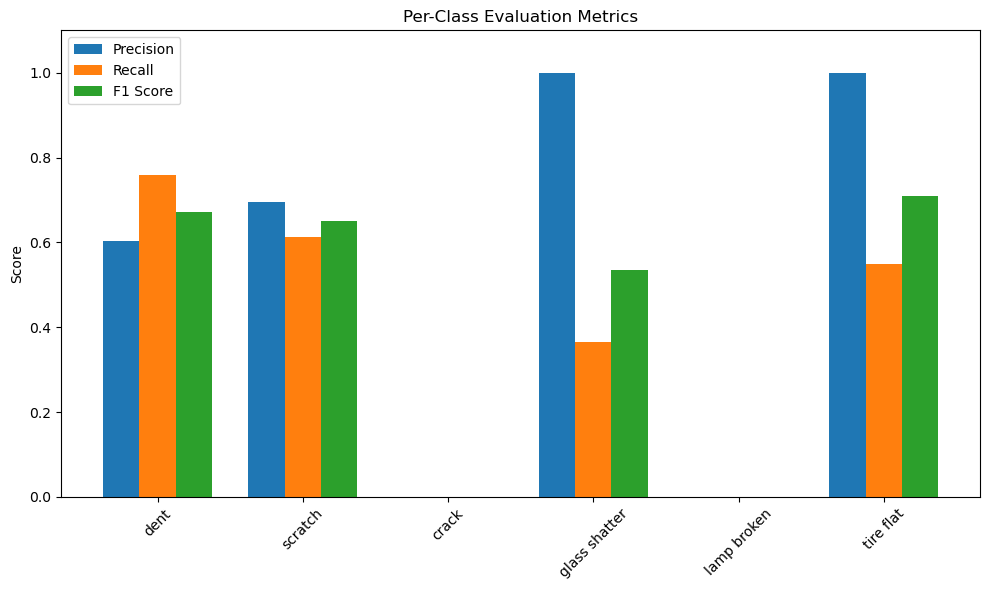

True label counts: [157. 183.  48.  71.  65.  31.]
Predicted label counts: [197. 161.   0.  26.   0.  17.]


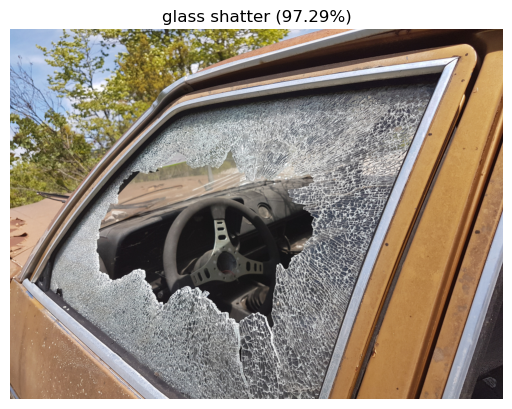

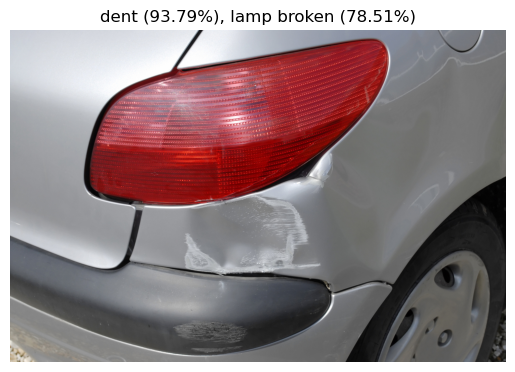

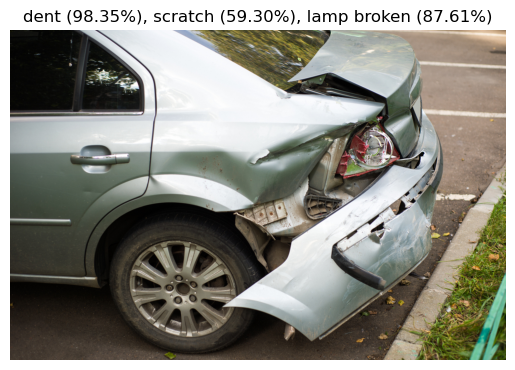

In [176]:
#This cell
# 1. Loads a ResNet-18 model, modifies its output layer for 6 damage categories, and loads trained weights.
# 2. Prepares the model for evaluation on the appropriate device (CPU/GPU).
# 3. Applies image transformations to match the training data preprocessing.
# 4. Evaluates the model on the test set, calculating metrics like accuracy, precision, recall, and F1 score.
# 5. Visualizes per-class performance metrics.
# 6. Defines a function to predict car damage type for a given image, displaying the predicted label and confidence.
# 7. Tests the prediction function on a few images from the test folder.

#exact architecture from training
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 6),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('car_damage_model.pth'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#ttransformations (to match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

test_image_folder = '/Users/keenanwillison/Downloads/CarDD_release/CarDD_COCO/test2017'

damage_categories = {1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken', 6: 'tire flat'}

#adding in some accuracy metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (outputs > 0.5).float() #adjusted the threshold of 0.5 to see if we can get Recall and F1 to improve
        #by lowering the threshold, this will increase recall by allowing more predictions to be counted as "positive"
        #however, this has a bad affect on accuracy, which we want to be high

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

#adding visuals for the metrics
import matplotlib.pyplot as plt

classes = list(damage_categories.values())

precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)

precision_per_class = pad_metrics(precision_per_class)
recall_per_class = pad_metrics(recall_per_class)
f1_per_class = pad_metrics(f1_per_class)

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision_per_class, width=width, label='Precision')
plt.bar(x, recall_per_class, width=width, label='Recall')
plt.bar(x + width, f1_per_class, width=width, label='F1 Score')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics")
plt.legend()
plt.tight_layout()
plt.show()

print("True label counts:", all_labels.sum(axis=0))
print("Predicted label counts:", all_preds.sum(axis=0))

#Function to predict damage type for an image
#def predict_damage(image_path):
    #img = Image.open(image_path)
    
    #img_tensor = transform(img).unsqueeze(0).to(device)

    #running through the model to get predictions
    #with torch.no_grad():
        #output = model(img_tensor)
        
    #apply sigmoid and get the damage classification (class with the highest score)
    #output = output.squeeze().cpu().numpy() 
    #predicted_class = output.argmax()  #get the class with highest score

    #get the label for the predicted class
    #label = damage_categories[predicted_class + 1]  # +1 because IDs are 1-indexed
    #confidence = output[predicted_class]  # Confidence for the predicted class
    
    #return label, confidence

def predict_damage(image_path, threshold=0.5):
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Run through the model to get predictions
    with torch.no_grad():
        output = model(img_tensor)

    # Apply sigmoid to get probabilities
    output = output.squeeze().cpu().numpy()
    
    # Get all classes with scores above the threshold
    predicted_classes = [i for i, score in enumerate(output) if score > threshold]
    
    # Get the corresponding labels and their confidence scores
    labels = [damage_categories[i + 1] for i in predicted_classes]  # +1 because IDs are 1-indexed
    confidences = [output[i] for i in predicted_classes]
    
    return labels, confidences

#testing with the first 3 images in the 'test2017' folder
test_images = os.listdir(test_image_folder)[:3]

#for image_name in test_images:
    #image_path = os.path.join(test_image_folder, image_name)
    #label, confidence = predict_damage(image_path)
    #img = Image.open(image_path)
    #plt.imshow(img)
    #plt.title(f'{label} ({confidence*100:.2f}% confidence)')
    #plt.axis('off')
    #plt.show()

for image_name in test_images:
    image_path = os.path.join(test_image_folder, image_name)
    labels, confidences = predict_damage(image_path)
    img = Image.open(image_path)
    
    # Format the labels and confidences for display
    label_text = ', '.join([f'{label} ({confidence*100:.2f}%)' for label, confidence in zip(labels, confidences)])
    
    plt.imshow(img)
    plt.title(label_text)
    plt.axis('off')
    plt.show()

### Graph Analysis:
The main finding that pops out here is that "crack" and "lamp broken" had zero true positives, zero predicted positives, and zero true labels in the test set. This means that the model never predicted those classes.  As we can see from the printed statement right under the graph, the true labels do include "crack" and "lamp broken", but our model never predicts them. As discussed right after, our model is conservative, so it's less likely to guess a label unless it's very confident -- meaning it might skip these rarer categories entirely.

### Accuracy Metrics Analysis:

#### Accuracy: 0.3717
This means the model got all of the labels correct for roughly 37.2% of the test images. In multi-label classification, this is a very strict metric because the model has to get all of the potential damages correct. Even if one of the six labels is wrong, the prediction is considered incorrect. So, this is expected to be relately low for multi-label tasks compared to single-labeled ones.

#### Precision: 0.5500
Since precision is the percent of positive classifications that actually had positive labels, this means across the six labels, the model was right about 55% of the time it made a positive prediction. What does this mean about our model? Well, it could mean we have a conservative model, meaning it avoids false positives reasonably well. This could be important in our insurance case because if there are a lot of false positives, the insurer may pay out unnecessarily.

#### Recall: 0.3808
Since recall is the percent of positive labels that were actually found, at around 38%, our model is missing a lot of true damage cases. So, it's not great at finding all of the damage present.

#### F1-Score: 0.4280
Since this is the harmonic mean of precision and recall, a score of roughly 0.43 reflects a moderate trade-off between the model's ability to identify damage without producing too many false alarms.

By lowering the threshold, recall, precision, and F1-score all increase, but at the cost of accuracy. We'd still like an accurate model. We found that threshold of 0.5 leads to the highest accuracy, and a relatively high precision at the cost of recall.

Notes on different architectures:

ResNet:

EfficientNet:

